In [1]:
import pandas as pd
import numpy as np
np.random.seed(2017)

from sklearn.model_selection import GroupKFold

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#!pip install ml_metrics
from ml_metrics import rmsle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('../input/test.csv', parse_dates=['datetime'])

df_all = pd.concat([df_train, df_test])

## Success metric

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

where  
**n** is the number of hours in the test set  
**pi** is your predicted count  
**ai** is the actual count  
**log(x)** is the natural logarithm  

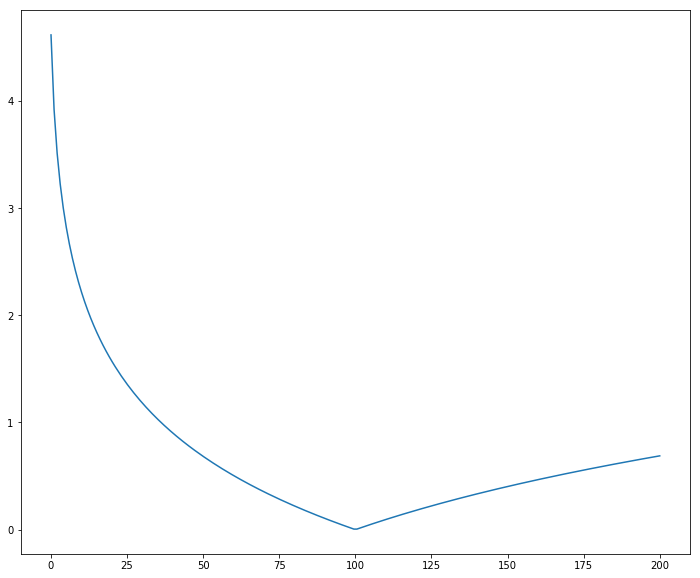

In [3]:
fig = plt.figure(figsize=(12, 10))

y_true = [100]
y_preds = np.linspace(0, 200, 200)

err    = [ rmsle(y_true, [y_pred]) for y_pred in y_preds ]
plt.plot(y_preds, err);

In [4]:
def get_feats(df, black_list=['count', 'casual', 'registered']):
    feats = df.select_dtypes(include=[np.int64, np.float64]).columns.values
    
    def allow_feat(feat):
        for block_feat in black_list:
            if block_feat in feat: return False
        return True
    
    return [feat for feat in feats if allow_feat(feat) ]

get_feats(df_train)

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

## Basic Line

In [5]:
feats = get_feats(df_train)
X = df_train[feats].values
y = df_train['count'].values

model = DummyRegressor(strategy='median')
model.fit(X, y)
y_pred = model.predict(X)

rmsle(y, y_pred)

1.4725894242962372

## Submit 1 => 1.48064

In [6]:
X = df_test[feats].values

df_test['count'] = model.predict(X)
df_test[ ['datetime', 'count'] ].to_csv('../output/dummy_median.csv', index=False)

## How to make a submit?
1. Go to [Kaggle](http://kaggle.com) and make account if you still don't have it
2. Type "bike sharing" and select first one ("Bike Sharing Demand")
3. Click "Late Submission"
4. Upload a file
5. Check result and be happy :)

![](../images/bike_sharing_demand.png)
![](../images/submission.png)

### Submit `dummy_median.csv`
![](../images/dummy_median_output.png)

## Model #2: [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree)

In [7]:
feats = get_feats(df_train)
X = df_train[feats].values
y = df_train['count'].values

model = DecisionTreeRegressor(max_depth=5, random_state=2018)
model.fit(X, y)
y_pred = model.predict(X)

rmsle(y, y_pred)

1.3345865242240684

### Dates

In [8]:
def feats_engineering(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    return df

In [9]:
feats = get_feats(feats_engineering(df_train))
X = df_train[feats].values
y = df_train['count'].values

model = DecisionTreeRegressor(max_depth=5, random_state=2018)
model.fit(X, y)
y_pred = model.predict(X)

rmsle(y, y_pred)

0.60214088889979633

### Submit 2 => 0.69329

In [10]:
X = feats_engineering(df_test)[feats].values

df_test['count'] = model.predict(X)
df_test[ ['datetime', 'count'] ].to_csv('../output/decision_tree_5depth.csv', index=False)

![](../images/decision_tree_0.693.png)

## Overfitting
Do you see, the difference between local result (0.602) and kaggle one (0.693)? This happened because we train and verify a quality of the model on same data. We need change this, because in next steps we'll do much more "aggressive" optimization.


## Custom Validation

In [11]:
df = feats_engineering(df_test)
df[ ['year', 'month', 'count'] ].groupby(['year', 'month']).agg(len)

count
year month       
2011 1      257.0
     2      203.0
     3      284.0
     4      264.0
     5      288.0
     6      264.0
     7      288.0
     8      275.0
     9      264.0
     10     288.0
     11     263.0
     12     285.0
2012 1      288.0
     2      237.0
     3      288.0
     4      264.0
     5      288.0
     6      264.0
     7      288.0
     8      288.0
     9      264.0
     10     252.0
     11     263.0
     12     286.0

In [12]:
df = feats_engineering(df_train)
df[ ['year', 'month', 'count'] ].groupby(['year', 'month']).agg(len)

count
year month       
2011 1        431
     2        446
     3        446
     4        455
     5        456
     6        456
     7        456
     8        456
     9        453
     10       455
     11       456
     12       456
2012 1        453
     2        455
     3        455
     4        454
     5        456
     6        456
     7        456
     8        456
     9        456
     10       456
     11       455
     12       456

In [13]:
def custom_validation(df, feats, target_variable='count', n_folds=3):
    X = df[feats].values
    y = df[target_variable].values

    groups = df['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [14]:
feats = get_feats(feats_engineering(df_train))

models, scores = [], []

for idx, (X_train, X_test, y_train, y_test) in enumerate(custom_validation(df_train, feats, target_variable='count')):
    model = DecisionTreeRegressor(max_depth=5, random_state=2018)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = rmsle(y_test, y_pred)
    
    models.append(model)
    scores.append(score)


np.mean(scores), np.std(scores)

(0.62055209225284058, 0.012500817435605218)

## Count = Registered + Casual
First, let's check that this assumption is true.

In [26]:
df_train[ df_train['count'] != df_train['registered'] + df_train['casual'] ].shape

(0, 17)

Ok, looks good :). Now, let's build two separeted model. First one will predict `registered` and second one `casual`. In the end just sum up: `count_pred` = `registered_pred` + `casual_pred` 

### Two models: Registered + Casual

In [16]:
df = feats_engineering(df_train)
feats = get_feats(df)

groups = df_train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
    
X = df[feats].values
registered = df_train['registered'].values
casual = df_train['casual'].values
count = df_train['count'].values

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):

    model = DecisionTreeRegressor(max_depth=5, random_state=2018)
    model.fit(X[train_idx], registered[train_idx])
    registered_pred = model.predict(X[test_idx])
    
    model = DecisionTreeRegressor(max_depth=5, random_state=2018)
    model.fit(X[train_idx], casual[train_idx])
    casual_pred = model.predict(X[test_idx])
    
    count_pred = registered_pred + casual_pred
    
    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.60825573003644307, 0.018690969969970269)

## Logarithm transformation

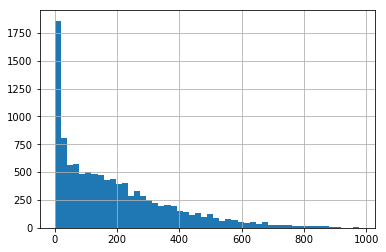

In [17]:
df_train['count'].hist(bins=50);

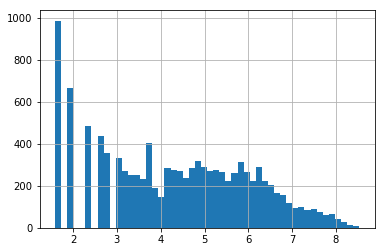

In [34]:
np.log2( df_train['casual'] + 3).hist(bins=50);

In [19]:
df_train['count_log'] = np.log( df_train['count'] + 1 )

In [20]:
df = feats_engineering(df_train)
feats = get_feats(df)

groups = df_train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
    
X = df[feats].values

count = df_train['count'].values
offset_log = 6
count_log = np.log2( count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):

    model = DecisionTreeRegressor(max_depth=5, random_state=2018)
    model.fit(X[train_idx], count_log[train_idx])
    count_log_pred = model.predict(X[test_idx])
    
    count_pred = np.exp2( count_log_pred) - offset_log 

    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.60913467000164234, 0.011216467110148148)

In [21]:
df = feats_engineering(df_train)
feats = get_feats(df)

groups = df_train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
    
X = df[feats].values
offset_log = 3

registered = df['registered'].values
registered_log = np.log2(registered + offset_log)

casual = df['casual'].values
casual_log = np.log2(casual + offset_log)

count = df['count'].values
count_log = np.log2(count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):
    model = DecisionTreeRegressor(max_depth=5, random_state=2018)
    model.fit(X[train_idx], registered_log[train_idx])
    registered_log_pred = model.predict(X[test_idx])
    registered_pred = np.exp2(registered_log_pred) - offset_log
    
    model = DecisionTreeRegressor(max_depth=5, random_state=2018)
    model.fit(X[train_idx], casual_log[train_idx])
    casual_log_pred = model.predict(X[test_idx])
    casual_pred = np.exp2(casual_log_pred) - offset_log
    
#     model = DecisionTreeRegressor(max_depth=5, random_state=2018)
#     model.fit(X[train_idx], count_log[train_idx])
#     count_log_pred = model.predict(X[test_idx])
#     count_pred_1 = np.exp2(count_log_pred) - offset_log
    
    count_pred = registered_pred + casual_pred
    #count_pred = 0.7*(registered_pred + casual_pred) + 0.3*count_pred_1
    
    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.58745725499496981, 0.0094175840137115958)

##  Submit => 0.67261

In [22]:
train = feats_engineering(df_train)
test = feats_engineering(df_test)

feats = get_feats(train)
X_train, X_test = train[feats].values, test[feats].values

offset_log = 3

registered = train['registered'].values
registered_log = np.log2(registered + offset_log)

casual = train['casual'].values
casual_log = np.log2(casual + offset_log)

count = train['count'].values
count_log = np.log2(count + offset_log)

In [23]:
model_registered = DecisionTreeRegressor(max_depth=5, random_state=2018)
model_registered.fit(X_train, registered_log)

model_casual = DecisionTreeRegressor(max_depth=5, random_state=2018)
model_casual.fit(X_train, casual_log)

registered_log_pred = model_registered.predict(X_test)
registered_pred = np.exp2(registered_log_pred) - offset_log

casual_log_pred = model_casual.predict(X_test)
casual_pred = np.exp2(casual_log_pred) - offset_log

test['count'] = registered_pred + casual_pred

In [24]:
test[ ['datetime', 'count'] ].to_csv('../output/dt_log_registered_casual.csv', index=False)

![](../images/0.67261.png)